In [293]:
import sqlite3
from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

## Model 1 - Texts as they are

In [294]:
#load psychological data
cols = ['id', 'sex', 'HEX1_eX', 'HEX2_A', 'HEX3_C', 'HEX4_E', 'HEX5_O', 'HEX6_H']
traits = pd.read_csv('data/survey_data.csv', sep=';', decimal=',', usecols=cols)
traits.shape

(152, 8)

In [295]:
#get text data from db
conn = sqlite3.connect('ud.db')
c = conn.cursor()
c.execute('SELECT DISTINCT owner_id, text FROM posts WHERE text IS NOT NULL AND text != "";')
texts = pd.DataFrame.from_records(c.fetchall())
texts.columns = ['id', 'text']
c.close()
conn.close()
texts.shape

(38375, 2)

Filter out short texts

Mean: 365.70241973 
Median: 325.0 
Min: 201 
Max: 699


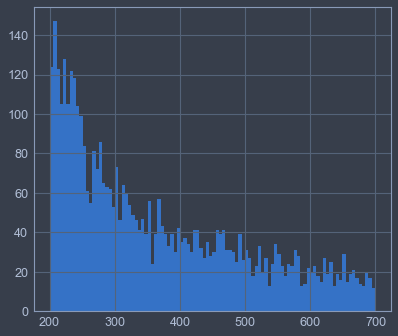

In [301]:
lens = np.array([len(str(t)) for t in texts.text])
print('Mean:', lens.mean(),
      '\nMedian:', np.median(lens), '\nMin:', min(lens), '\nMax:', max(lens))
plt.hist(lens, bins=100);

In [298]:
trsh_up = 700
print('{:.2f}% постов короче {} б.'.format(lens[lens<trsh_up].shape[0]/lens.shape[0]*100, trsh_up))
trsh_lo = 200
print('{:.2f}% постов длиннее {} б.'.format(lens[lens>trsh_lo].shape[0]/lens.shape[0]*100, trsh_lo))

94.32% постов короче 700 б.
16.88% постов длиннее 200 б.


In [299]:
lens = np.array([len(str(t)) for t in texts.text])
texts = texts[(lens < trsh_up) & (lens > trsh_lo)]
texts.shape

(4298, 2)

In [300]:
#join data
data = pd.merge(texts, traits, how='left', left_on='id', right_on='id')
data.shape

(4532, 9)

In [285]:
data.text = data.text.str.lower()

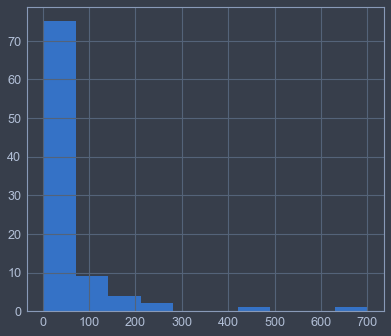

In [302]:
data.groupby('id').text.count().hist();

In [303]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def build_model(data, X, y, vectorizer, model):
    print('\nBUILDING MODEL FOR {}'.format(y))
    
    X_train, X_test, y_train, y_test = train_test_split(data[X], data[y], test_size=0.2)
    
    print('Train sample: {}\nTest sample: {}'.format(len(X_train), len(X_test)))
    
    print('\n...running vectorizer...\n')
    
    train_vec = vectorizer.fit_transform(X_train)
    test_vec = vectorizer.transform(X_test)
     
    print('Included tokens ({})'.format(train_vec.shape[1]))
    print(np.array(vectorizer.get_feature_names())[np.random.randint(0, len(vectorizer.get_feature_names()), 20)])
    print('\nExcluded tokens ({})'.format(len(vectorizer.stop_words_)))
    print(np.array(list(vectorizer.stop_words_))[np.random.randint(0, len(vectorizer.stop_words_), 20)])
    
    print('\n...fitting model...')
    model.fit(train_vec, y_train)
    
    y_train_pred = model.predict(train_vec)
    print('\nMAPE on training sample: {:.2f}%'.format(mape(y_train, y_train_pred)))
    print('R2 on training sample: {:.3f}'.format(r2_score(y_train, y_train_pred)))

    y_test_pred = model.predict(test_vec)
    print('\nMAPE on test sample: {:.2f}%'.format(mape(y_test, y_test_pred)))
    print('R2 on training sample: {:.3f}'.format(r2_score(y_test, y_test_pred)))
    
    print('High pole')
    [print(a) for a in sorted(list(zip(model.coef_, vectorizer.get_feature_names())), reverse=True)[0:10]]
    print('\nLow pole')
    [print(a) for a in sorted(list(zip(model.coef_, vectorizer.get_feature_names())))[0:10]]

In [304]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                         analyzer='word', 
                         tokenizer=word_tokenize, 
                         min_df = 50, 
                         max_df = 0.8, 
                         max_features = 5000)

In [305]:
lm = LinearRegression()

In [306]:
%%time
for trait in ['HEX1_eX', 'HEX2_A', 'HEX3_C', 'HEX4_E', 'HEX5_O', 'HEX6_H']:
    lm = LinearRegression()
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                         analyzer='word', 
                         tokenizer=word_tokenize, 
                         min_df = 50, 
                         max_df = 0.8, 
                         max_features = 5000)
    build_model(data, X='text', y=trait, vectorizer=vectorizer, model=lm)


BUILDING MODEL FOR HEX1_eX
Train sample: 3625
Test sample: 907

...running vectorizer...

Included tokens (509)
['слова' 'своих' 'совершенно' 'вопрос' 'но' 'которых' ') и' 'есть' 'лет'
 ') ,' 'слишком' 'всё' 'здесь' 'такие' 'совсем' 'руки' 'кажется ,'
 'если вы' 'моей' 'of']

Excluded tokens (193233)
['несопоставимые ни' 'и ваших' 'нужно ничего' 'пятницу я' 'банно-прачечный'
 'паркету стук' 'понятия четче' 'рождается тот' ', край' 'преференции в'
 'везувия !' 'светились близлежащие' 'игнорировать .' 'пропозициональные'
 'документе или' 'изобретения »' 'требованию ,' 'изюма из' 'алгоритм'
 '( энмеркар']

...fitting model...

MAPE on training sample: 15.27%
R2 on training sample: 0.413

MAPE on test sample: 17.41%
R2 on training sample: 0.187
High pole
(48.40559661303584, '©')
(41.653026200894331, '» (')
(36.362069446939664, '«')
(25.810479311519273, '. «')
(23.969311633038551, '. ©')
(20.979967805803685, 'того ,')
(19.350064119850877, '. (')
(18.347398591205021, 'любви')
(18.2586733245